## 3.3 一般化線形モデル：ポアソン回帰モデル

In [2]:
%matplotlib inline

import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from scipy import stats
import seaborn as sns

sns.set()

### 3.3.1 モデル概要

**一般化線形モデル**

$$
\begin{align*}
    y_n &\sim p(y_n | \theta_n) \\
    \theta_n &= f^{-1}(w_1 x_n + w_2)
\end{align*}
$$

$f$: 逆リンク関数 (inverse link function)
$f^{-1}$: リンク関数 (link function)


**ポアソン回帰モデル**

$$
\begin{align}
    y_n | \lambda_n \sim \text{Poi}(y_n | \lambda_n) = \frac{\lambda_n^{y_n} \exp{(- \lambda_n)}}{y_n !} \\
    \lambda_n = \exp{(w_1 x_n + w_2)} \in \mathbb{R}^{+}
\end{align}
$$

### 3.2.2 実装

$$
\begin{align*}
    &y_n | \lambda_n \sim \text{Poi}(y_n | \lambda_n) = \frac{\lambda_n^{y_n} \exp{(-\lambda_n)}}{y_n !} \\
    &\lambda_n = \exp{(w_1 x_n + w_2)} \\
\end{align*}
$$

$w_1, w_2$ の事前分布は以下とする
$$
\begin{align*}
    &w_1 \sim \mathcal{N}(0, \sigma_{w_1}^2) \\
    &w_2 \sim \mathcal{N}(0, \sigma_{w_2}^2) \\
\end{align*}
$$

テストデータは以下の通り.

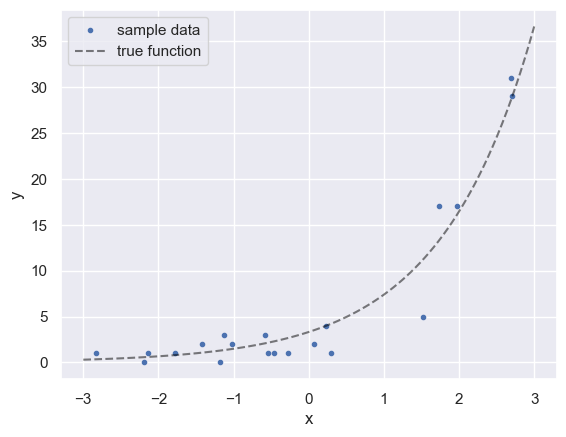

In [3]:
# データ数
N = 20

# 真のパラメータ
true_w1 = 0.8
true_w2 = 1.2

# サンプルデータ
rng = np.random.default_rng(seed=1)
x_data = rng.uniform(-3, 3, N)
y_data = stats.poisson(mu=np.exp(true_w1 * x_data + true_w2)).rvs()

x_plot_data = np.linspace(-3, 3, 100)
y_plot_data = stats.poisson(mu = np.exp(true_w1 * x_plot_data + true_w2)).mean()
plt.scatter(x_data, y_data, marker=".", label="sample data")
plt.plot(x_plot_data, y_plot_data, label="true function", color="black", linestyle="--", alpha=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [4]:
with pm.Model() as model:
    # 説明変数
    x = pm.Data("x", x_data)

    # 推論パラメータの事前分布
    w1 = pm.Normal("w1", mu=0.0, sigma=1.0)
    w2 = pm.Normal("w2", mu=0.0, sigma=1.0)

    # 尤度関数
    y = pm.Poisson("y", mu=pm.math.exp(w1 * x + w2), observed=y_data)

In [5]:
with model:
    # MCMC による推論
    trace = pm.sample(draws=3000, tune=1000, chains=3, random_seed=1, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [w2, w1]


/Users/yuta.sonoda/opt/anaconda3/envs/bayes_ml/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 12 seconds.
The acceptance probability does not match the target. It is 0.8809238882594098, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'w1'}>,
        <AxesSubplot:title={'center':'w1'}>],
       [<AxesSubplot:title={'center':'w2'}>,
        <AxesSubplot:title={'center':'w2'}>]], dtype=object)

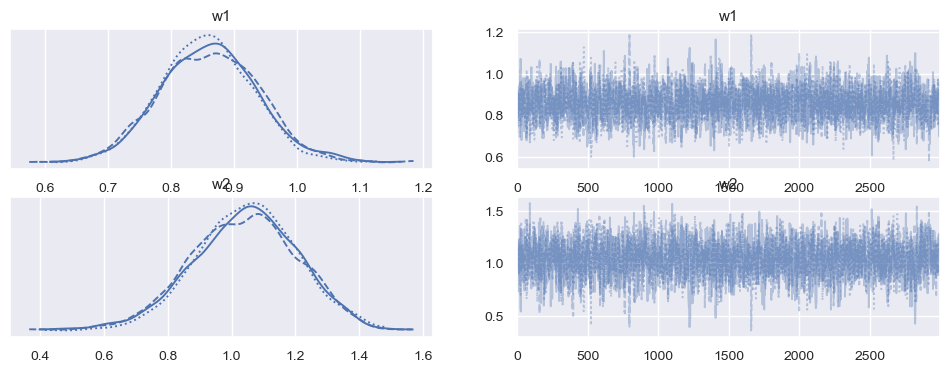

In [6]:
az.plot_trace(trace)

In [7]:
for var_info in az.rhat(trace).values():
    print(var_info.name, var_info.values.round(3), sep=" ")

w1 1.002
w2 1.002


array([<AxesSubplot:title={'center':'w1'}>,
       <AxesSubplot:title={'center':'w2'}>], dtype=object)

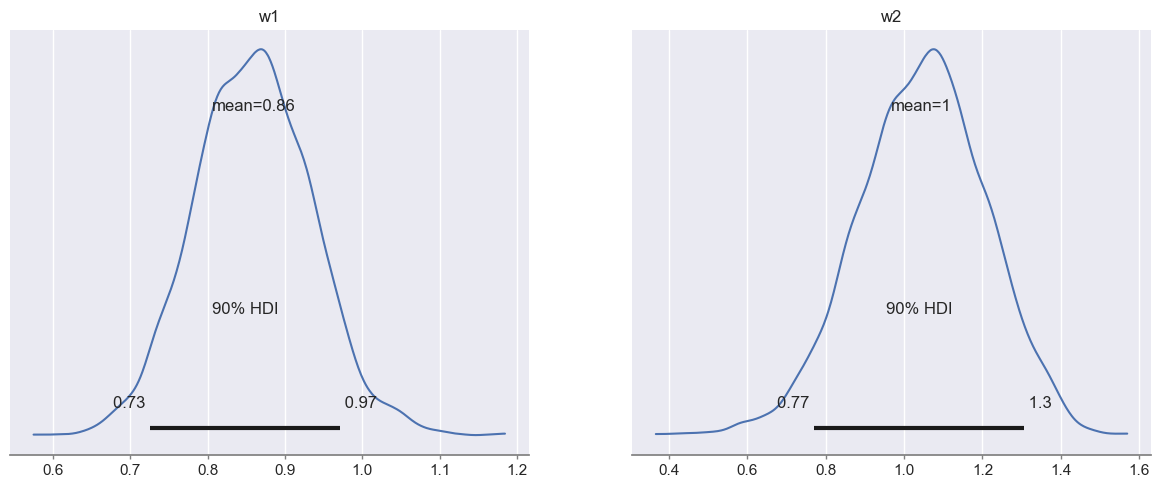

In [8]:
az.plot_posterior(trace, hdi_prob=0.90)

/Users/yuta.sonoda/opt/anaconda3/envs/bayes_ml/lib/python3.10/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


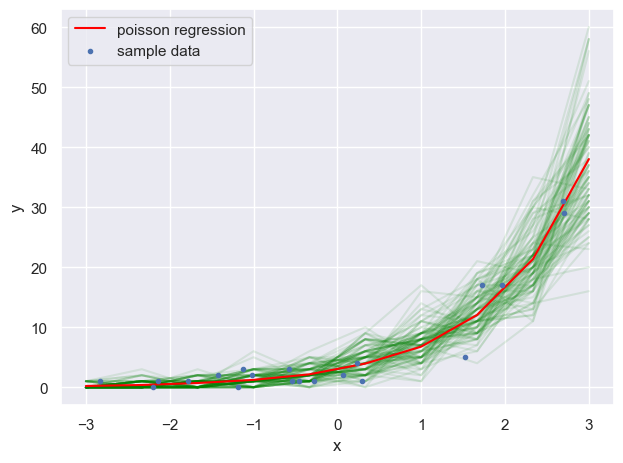

In [10]:
# 検証用データ
x_new = np.linspace(-3, 3, 10)

with model:
    # 検証用データを推論したモデルに入力
    pm.set_data({"x": x_new})

    # 予測分布からサンプリング
    pred = pm.sample_posterior_predictive(trace, samples=1000, random_seed=1)

y_pred_samples = pred["y"]

# 予測分布からのサンプルを一部描画
for i in range(0, 1000, 10):
    plt.plot(x_new, y_pred_samples[i, :], alpha=0.1, zorder=i + 1, color="green")

# 予測分布からのサンプルの平均を描画
plt.plot(x_new, y_pred_samples.mean(axis=0), alpha=1.0, label="poisson regression", zorder=i + 1, color="red")

# データ点を描画
plt.scatter(x_data, y_data, marker=".", label="sample data", zorder=i + 2)

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()